# **Instalo Tensorflow 2.16.1:** con la version 2.15.0 por defecto de Kaggle al ser exportado el modelo pierde precision en dispositivos locales que usan tensorflow 2.16.1

In [1]:
!pip install tensorflow==2.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ten

# **Importando librerias necesarias y dando pasos iniciales**

1. **Creo el arreglo data vacio**
2. **Defino una funcion para mostrar una imagen** 
3. **Creo las posibles etiquetas de salida a partir de las carpetas en que se divide el dataset**

In [2]:
import os
import glob
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout


data = []

#Cargar los datos con OpenCv
paths = ["/kaggle/input/real-life-violence-situations/new_violence"]

#Mostrar imagen
def imshow(img):
    fig,ax = plt.subplots(1,1,figsize = (5,5))
    ax.imshow(img)
    plt.show()

#agregar las etiquetas de salida dadas las carpetas con su nombre
possible_labels = os.listdir(paths[0])
print(possible_labels)

print(f"TensorFlow Version: {tf.__version__}")

['non_violence', 'violence']
TensorFlow Version: 2.16.1


# **Guardando los datos en el array data:**

**Recorriendo las posibles etiquetas de salida y tomando su indice y valor se realiza una busqueda con glob.glob que busca archivos que coincidan con el patrón especificado, luego se verifica si la imagen se ha leido correctametne y se reajusta a 320 x 320 (Tamaño predeterminado de las imagenes del dataset)**

In [3]:
for label_int, label_str in enumerate(possible_labels):
       for filename in glob.glob(os.path.join(paths[0],label_str, "*.jpg")):
            img = cv2.imread(filename.replace("\\", "/"))
            if img is not None:  # Verificar si la imagen se ha leído correctamente
                try:
                    resized_img = cv2.resize(img, (320, 320))
                    data.append([label_int, resized_img])
                except Exception as e:
                    print(f"Error resizing image {filename}: {e}")
            else:
                print(f"Warning: Unable to read image {filename} Please check the file path and format.")
print(len(data))

11073


# **Insertando los datos (training, validacion y testing) en arrays de numpy** 

**Se barajan y dividen los datos de imágenes en conjuntos de entrenamiento, validación y prueba distribuidos en difrentes porcentajes dejando el 80% para el conjunto de entrenamiento, y luego se convierten estos conjuntos en arreglos de NumPy para su uso en TensorFlow.**

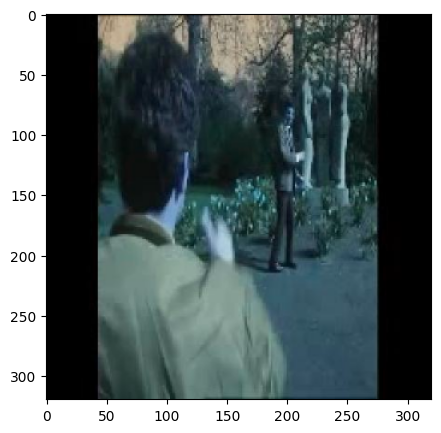

non_violence


In [4]:
#Se Barajea el arreglo data para que no inserte los datos por carpetas
random.Random(0).shuffle(data)

#Se crea arreglos para los conjuntos de validacion, tewsting y entrenamiento
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

#Se recorre la lista data para agregar las imagenes a sus correspondientes arreglos
for i,sample in enumerate(data):
    label= sample[0]
    img = sample[1]
    if i <= 0.8*len(data):
        x_train.append(img)
        y_train.append(label)
    elif i >0.8*len(data) and i <= 0.9*len(data):
        x_val.append(img)
        y_val.append(label)
    else:
        x_test.append(img)
        y_test.append(label)

#Convirtiendo los arrays en arreglos de NumPy para Tensorflow
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

#Mostrar Imagen en la pos 0
imshow(x_train[0])
print(possible_labels[y_train[0]])

# **Convirtiendo las labels de las imagenes en One-Hot Encoding**

**Se convierten las etiquetas de los conjuntos de entrenamiento, validación y prueba en representaciones one-hot, que es una forma común de representar etiquetas categóricas.**

In [5]:
y_trainOneHot = tf.one_hot(y_train,len(possible_labels))
y_valOneHot = tf.one_hot(y_val,len(possible_labels))
y_testOneHot = tf.one_hot(y_test,len(possible_labels))
print("done")

done


# **Definiendo el modelo**

**Se construye y devuelve una CNN (Red Neuronal Convolucional). Utiliza varias capas convolucionales con activación ReLU, normalización por lotes y max-pooling para extraer características, seguido de capas densas para la clasificación final. Se utiliza la regularización L2 para prevenir el sobreajuste y se compila el modelo con el optimizador Adam (Adaptive Moment Estimation) y la pérdida de entropía cruzada categórica.**

In [6]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

def cnn_model():
    model = Sequential()
    model.add(Input(shape=(320, 320, 3)))
    model.add(Convolution2D(32, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(128, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(256, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dense(len(possible_labels), activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [7]:
model = cnn_model()
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 318, 318, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 318, 318, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 159, 159, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 157, 157, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 157, 157, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 78, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 76, 76, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 76, 76, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 36, 36, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 36, 36, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    42,467,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,993,090 (164.01 MB)

 Trainable params: 42,990,594 (164.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

None


# **Guardando el proceso automaticamente y configurando Tensorboard**

**Se configura TensorBoard para visualizar el progreso y ModelCheckpoint para guardar automáticamente el mejor modelo basado en la precisión de validación (val_accuracy).**

In [8]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

log_dir = "logs/cnn_logs/train"
os.makedirs(log_dir, exist_ok=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq = 1)

print(x_train.shape)

(8859, 320, 320, 3)


# **Entrenando el Modelo**

In [9]:
model.fit(
    x_train,
    y_trainOneHot,
    epochs = 20,
    batch_size = 64,
    validation_data = (x_val, y_valOneHot),
    callbacks = [tensorboard_callback, checkpoint]
)

Epoch 1/20


I0000 00:00:1717967420.651985      82 service.cc:145] XLA service 0x7c611c005320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717967420.652067      82 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-06-09 21:10:23.196889: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,32,318,318]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,320,320]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-06-09 21:10:23.638691: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 9337: 4.03405, expected

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7725 - loss: 2.8684

2024-06-09 21:10:54.223194: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 921: 5.8781, expected 5.16091
2024-06-09 21:10:54.223260: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2372: 5.67886, expected 4.96167
2024-06-09 21:10:54.223274: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3295: 5.5146, expected 4.79741
2024-06-09 21:10:54.223282: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3337: 5.57453, expected 4.85734
2024-06-09 21:10:54.223293: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4102: 6.15528, expected 5.43809
2024-06-09 21:10:54.223303: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4520: 5.74603, expected 5.02884
2024-06-09 21:10:54.223313: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5207: 6.07665, expected 5.35947
2024-06-09 21:10:54.223324: E external/local

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7729 - loss: 2.8661

I0000 00:00:1717967463.918983      83 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads

2024-06-09 21:11:06.856960: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 505620: 8.34416, expected 7.39305
2024-06-09 21:11:06.857026: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 505621: 7.74864, expected 6.79753
2024-06-09 21:11:06.857051: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 505622: 7.97717, expected 7.02606
2024-06-09 21:11:06.857069: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 505623: 6.95818, expected 6.00707
2024-06-09 21:11:06.857088: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 505624: 7.82683, expected 6.87572
2024-06-09 21:11:06.857099: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 505


Epoch 1: val_accuracy improved from -inf to 0.73351, saving model to best_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 60s 289ms/step - accuracy: 0.7733 - loss: 2.8639 - val_accuracy: 0.7335 - val_loss: 2.3590
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8974 - loss: 1.5677
Epoch 2: val_accuracy improved from 0.73351 to 0.86179, saving model to best_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 181ms/step - accuracy: 0.8974 - loss: 1.5667 - val_accuracy: 0.8618 - val_loss: 1.3973
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9159 - loss: 1.1118
Epoch 3: val_accuracy did not improve from 0.86179
139/139 ━━━━━━━━━━━━━━━━━━━━ 39s 164ms/step - accuracy: 0.9159 - loss: 1.1115 - val_accuracy: 0.8464 - val_loss: 1.2594
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9255 - loss: 0.9309
Epoch 4: val_accuracy improved from 0.86179 to 0.86631, saving model to best_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 179ms/step - accuracy: 0.92

In [10]:
# Cargar el mejor modelo guardado
best_model = keras.models.load_model('best_model.keras')

# **Prediccion y salva del mejor modelo tanto en .h5 como en .json con sus pesos en .h5**

2024-06-09 21:19:01.855085: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 6.25329, expected 5.50563
2024-06-09 21:19:01.855293: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 7: 6.06822, expected 5.32056
2024-06-09 21:19:01.855310: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 8: 5.58897, expected 4.84131
2024-06-09 21:19:01.855319: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 9: 5.79339, expected 5.04572
2024-06-09 21:19:01.855328: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 10: 6.19196, expected 5.4443
2024-06-09 21:19:01.855335: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 18: 6.17255, expected 5.42489
2024-06-09 21:19:01.855343: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 20: 6.11393, expected 5.36627
2024-06-09 21:19:01.855351: E external/local_xla/xla/service

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step


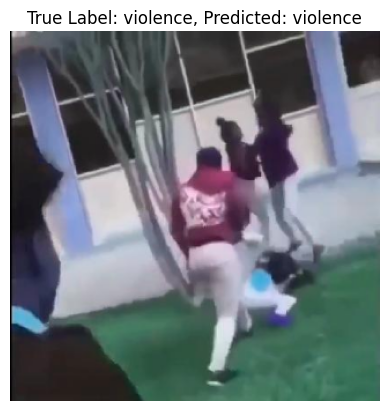

True Label: violence
Predicted Label: violence


In [11]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que tus datos de prueba están almacenados en x_test y y_test
# Selecciona una imagen aleatoria del conjunto de datos de prueba
random_index = random.randint(0, len(x_test) - 1)
random_image = x_test[random_index]
true_label = y_test[random_index]

# Realiza la predicción
prediction = best_model.predict(random_image[np.newaxis, ...])
predicted_label = possible_labels[np.argmax(prediction)]

# Muestra la imagen junto con la etiqueta verdadera y la predicción
plt.imshow(random_image)
plt.title(f"True Label: {possible_labels[true_label]}, Predicted: {predicted_label}")
plt.axis('off')
plt.show()

print(f"True Label: {possible_labels[true_label]}")
print(f"Predicted Label: {predicted_label}")


In [12]:
best_model.save('Modelo_Deteccion_Violencia.h5')

In [13]:
# Guarda la arquitectura del modelo en JSON
model_json = best_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Guarda los pesos del modelo en HDF5
best_model.save_weights("model.weights.h5")

**Se evalúa el mejor modelo guardado (best_model) en el conjunto de validación y muestra la precisión y pérdida de validación. Luego, se realiza predicciones sobre el conjunto de prueba y visualiza algunas de ellas seleccionando aleatoriamente imágenes del conjunto de prueba. Para cada imagen seleccionada, se muestra la imagen junto con su etiqueta verdadera y la etiqueta predicha por el modelo.**

2024-06-09 21:19:09.235779: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5499: 4.36668, expected 3.82808
2024-06-09 21:19:09.235917: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 15506: 4.36668, expected 3.82808
2024-06-09 21:19:09.236003: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 25511: 4.36668, expected 3.82808
2024-06-09 21:19:09.236082: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 35518: 4.36668, expected 3.82808
2024-06-09 21:19:09.236174: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 45523: 4.36668, expected 3.82808
2024-06-09 21:19:09.236260: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 55530: 4.36668, expected 3.82808
2024-06-09 21:19:09.236345: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 65535: 4.36668, expected 3.82808
2024-06-09 21:19:09.236430: E exter

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9342 - loss: 0.7323
Validation Accuracy: 0.92
Validation Loss: 0.77
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


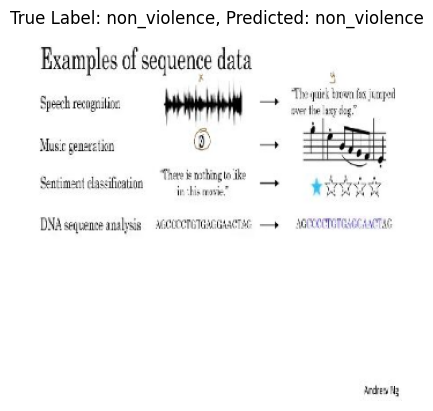

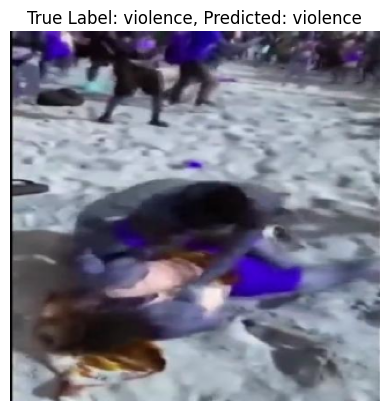

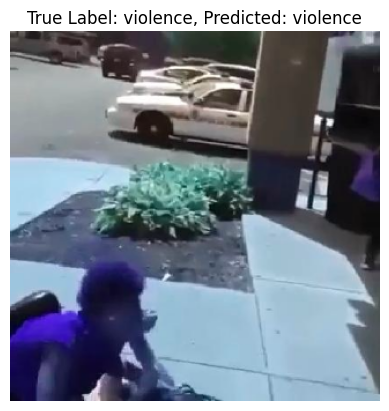

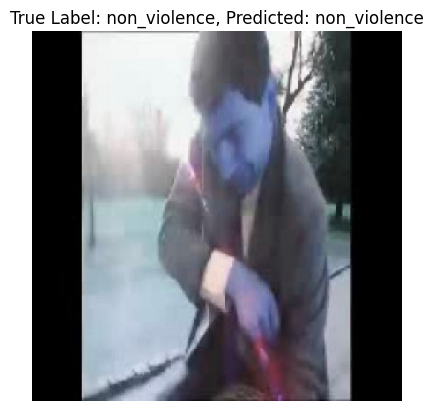

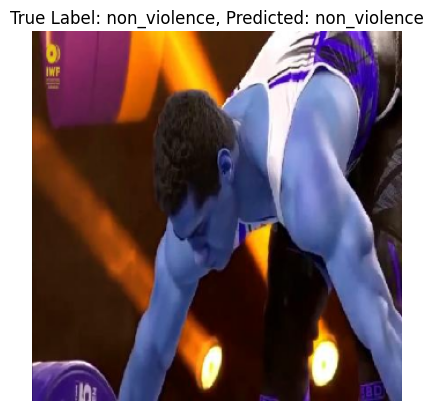

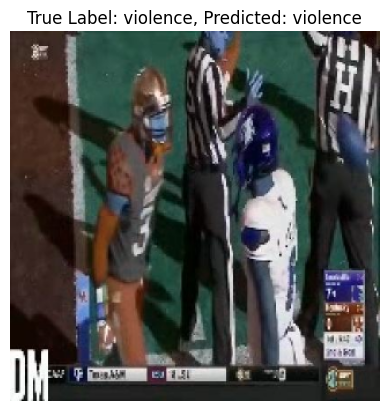

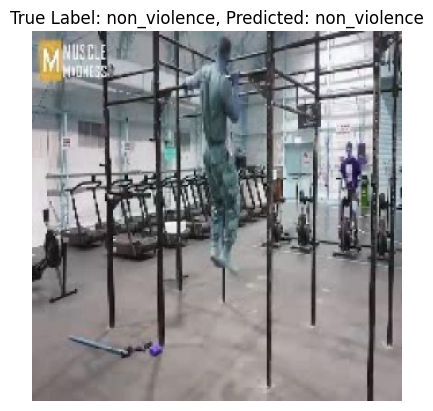

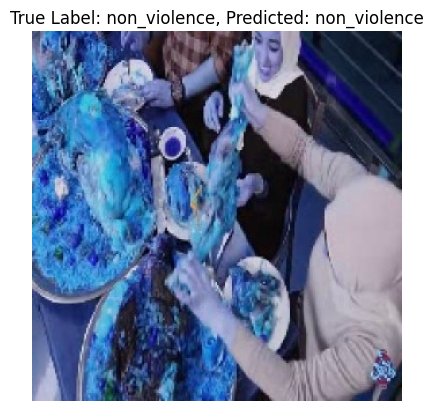

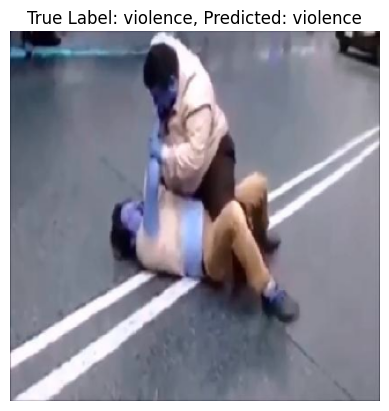

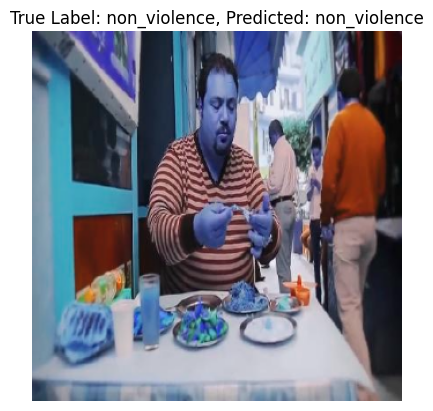

In [14]:
# Evaluar el modelo con datos de validación
val_loss, val_accuracy = best_model.evaluate(x_val, y_valOneHot)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print(f'Validation Loss: {val_loss:.2f}')

# Hacer predicciones en el conjunto de datos de prueba
predictions = best_model.predict(x_test)

# Visualizar algunas predicciones
num_samples = 10
for _ in range(num_samples):
    # Seleccionar una imagen aleatoria del conjunto de datos de prueba
    random_index = random.randint(0, len(x_test) - 1)
    random_image = x_test[random_index]
    true_label = y_test[random_index]
    
    # Realizar la predicción
    prediction = predictions[random_index]
    predicted_label = np.argmax(prediction)
    
    # Mostrar la imagen junto con la etiqueta verdadera y la predicción
    plt.imshow(random_image)
    plt.title(f'True Label: {possible_labels[true_label]}, Predicted: {possible_labels[predicted_label]}')
    plt.axis('off')
    plt.show()
